In [ ]:
# Extra: Generate requirements file
!pip install pipreqs

# Use one of these two to generate the file, check which one works
!pipreqs . --force
!pip freeze > requirements.txt

# Check the file
# Check the generated file
with open('requirements.txt', 'r') as file:
    print(file.read())

# If it's generated empty, check installed packages
pip list
# and then run one of the two generators.

# ⚠️ [S] DELTA Portfolio Task 3: Natural language processing

[s] [This is from the other element, thus need to be changed] <br>
The following jupyter notebook is the computational essay required for the subjet Delta. <br>
The goal is to perform a sentiment analysis on a database composed of tweets about an specific topic , alongside the necessary previous steps for it's application.<br>
Submitted by: <u>Sebastian Guardia (Student ID:640621)</u>

Your task is to perform sentiment analysis using a sentiment dictionary, an RNN model, a pre-trained Transformer and a fine-tuned Transformer. The data is separated into a train set of 1500 tweets and a test set of 500 tweets
**The structure of the notebook is as follows:**
1. Libraries and dataset loading.
2. Partitioning and scaling the dataset. 
3. Definition of dataset structure. 
4. Simple RNN Model.
5. LSTM Model.
6. Plotting predictions.
7. Conclusion.

# ⚠️ [Y] **DELTA ELEMENT 2: TIME SERISE FORECASTING USING RNN**

[This is from the other element, thus need to be changed] <br>
This notebook focuses on the development, training, and evaluation of neural network models for handling time-series data. Key concepts and techniques discussed include:

- **Time-Series Data Handling**: The use of functions to prepare time-series data for modeling with RNNs.

- **Data Partitioning**: Dividing data into training and test sets to ensure a robust evaluation of model performance and avoid overfitting. (Note: Last 20% of data from the laballed dataset forms the testset)

- **Model Checkpoints**: For saving the best performing models during training to prevent data loss and facilitate easy reloading for further use.

- **Training and Evaluation**: For assessing whether training was successful, including monitoring metrics like loss and accuracy on both training and validation datasets.

- **Model Performance Analysis**: Examining model performance through the evolution of training and validation loss, with specific attention to signs of overfitting or underfitting.

- **Visualization and Metrics**: Use of custom functions to plot model predictions against actual values and calculate the Mean Squared Error (MSE) to evaluate model accuracy.

- **RNN Architectures**: GRU (Gated Recurrent Unit) and LSTM (Long Short-Term Memory) networks and their capabilities to capture long-term dependencies in sequential data.

# ❌ ~~~

## Data Preprocessing

In [3]:
import pandas as pd

In [5]:
# Import dataframes
train_df = pd.read_parquet('datasets/btc_tweets_train.parquet.gzip')
test_df = pd.read_parquet('datasets/btc_tweets_test.parquet.gzip')

#Index resetting
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [7]:
train_df.head()

,tweet ID,hashtags,content,username,user_displayname,sentiment
0,1641579121972236290,"[Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...","$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,True
1,1641579176171016194,"[Bitcoin, bitcoinordinals, crypto]",Alright I have my rares. Who else is grabbing ...,spartantc81,SpartanTC,True
2,1641579486071390208,"[BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...","Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,SHIB Bezos,True
3,1641579537103302656,[BTC],📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,Algorithm.btc,True
4,1641579588399804418,[Bitcoin],"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,she is lucky,True


In [10]:
# ❓ What is this for? should we keep it?
#test_df.rename(columns={test_df.columns[0]: 'tweet ID'}, inplace=True)

In [16]:
# ❓ Do you think we should keep the head part? I'd get rid of it since we see it just above
# Take a first glance of the data base
def df_info(df):
    return df.shape, df.info(), df.isnull().sum().sum(),# df.head()

df_info(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          1500 non-null   int64 
 1   hashtags          1500 non-null   object
 2   content           1500 non-null   object
 3   username          1500 non-null   object
 4   user_displayname  1500 non-null   object
 5   sentiment         1500 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 60.2+ KB


((1500, 6), None, 0)

In [21]:
# Check for class imbalance
train_df['sentiment'].value_counts()

sentiment
True     1220
False     280
Name: count, dtype: int64

In [23]:
# ⚠️ Check if we are going to use username for the bot cleaning, otherwise delete that column as well
# Drop unnecessary columns
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)

In [39]:
# Snapshot of the dataframe we will be working with
train_df.head(3)

,content,username,sentiment
0,"$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,True
1,Alright I have my rares. Who else is grabbing ...,spartantc81,True
2,"Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,True


In [83]:
cleaned_train_df.head(3)

,content,username,sentiment,cleaned_content
0,Alright I have my rares. Who else is grabbing ...,spartantc81,True,alright rares else grabbing dogepunksbtc disco...
1,📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,True,loudspeaker xverse webbased pool live update x...
2,"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,True,yesterday bitcoin projection displayed europea...


## Text preparation for analysis

In [32]:
# ❓ Might want to delete this part, check
# Get the number of duplicated rows and remove any duplicates after that:
print('Number of duplicated samples: ',train_df[train_df.duplicated()].shape[0])
train_df = train_df.drop_duplicates(keep='first')

Number of duplicated samples:  0


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
import re
import emoji
from urllib.parse import urlparse

class DataPreprocessor:
    def __init__(self, df, content_column, sentiment_column):
        """
        Initialize the DataPreprocessor class with the DataFrame and relevant columns.

        Parameters:
        - df: pd.DataFrame
            The DataFrame containing the dataset.
        - content_column: str
            The name of the column containing the text content to analyze.
        - sentiment_column: str
            The name of the column containing the sentiment labels.
        """
        self.df = df
        self.content_column = content_column
        self.sentiment_column = sentiment_column
    
    def remove_similar_content(self, similarity_threshold=0.65):
        """
        Removes samples with similar content based on cosine similarity.

        Parameters:
        - similarity_threshold: float (default=0.65)
            The threshold for cosine similarity above which samples are considered similar.
        """
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(self.df[self.content_column])
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        indices_to_remove = set()

        for i in range(len(cosine_sim)):
            for j in range(i + 1, len(cosine_sim)):
                if cosine_sim[i, j] > similarity_threshold:
                    indices_to_remove.add(i)
                    indices_to_remove.add(j)

        self.df = self.df.drop(index=indices_to_remove).reset_index(drop=True)
        return self.df
    
# ❓ Are we going to add the part of deleting the fake usernames? It might add some extra points
    
    def clean_text(self):
        """
        Cleans text data by removing punctuation, stopwords, and applying lemmatization.
        """
        # ❓ Maybe we can get rid of this part, we download it every time we run the code
        #nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))

        def clean(tweet):
            # Convert emojis to text # Converts emojis to text, e.g., "😊" becomes ":smiling_face:"
            tweet = emoji.demojize(tweet, delimiters=(" ", " "))
            # Remove links
            tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
            # Remove punctuation and numbers
            tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
            # Tokenize
            words = nltk.word_tokenize(tweet)
            # Remove stop words
            words = [word for word in words if word.lower() not in stop_words]
            # Lemmatize words
            lemmatizer = nltk.WordNetLemmatizer()
            words = [lemmatizer.lemmatize(word.lower()) for word in words]
            return ' '.join(words)
        
        self.df['cleaned_content'] = self.df[self.content_column].apply(clean)
        return self.df
    
    def handle_class_imbalance_with_SMOTE(self):
        """
        Handles class imbalance using SMOTE (Synthetic Minority Over-sampling Technique).
        """
        
        tfidf = TfidfVectorizer(stop_words='english')
        X = tfidf.fit_transform(self.df[self.content_column])
        y = self.df[self.sentiment_column]
        
        # Apply SMOTE to the vectorized text
        smote = SMOTE(random_state=21)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        self.df = pd.DataFrame(X_resampled.toarray(), columns=tfidf.get_feature_names_out())
        self.df[self.sentiment_column] = y_resampled
        return self.df
# ❓ This is not funciontal yet isn't it?
    
    def preprocess(self, remove_similar=True, balance_classes=True, clean_text=True):
        """
        Performs the full preprocessing pipeline.

        Parameters:
        - remove_similar: bool (default=True)
            Whether to remove similar content.
        - balance_classes: bool (default=True)
            Whether to handle class imbalance.
        - clean_text: bool (default=True)
            Whether to clean text data.
        """
        if remove_similar:
            self.remove_similar_content()
        if balance_classes:
            self.handle_class_imbalance_with_SMOTE()
        if clean_text:
            self.clean_text()

        return self.df

🔷 Argumentation of the usage of: <br>
    Cosine similarity <br>
    Why we decided to deal with class imbalance this way

In [ ]:
# ⚠️This was needed to run
!pip install emoji

In [ ]:
# Initialize the class object for both 'train' and 'test' datasets
train_preprocesser = DataPreprocessor(df=train_df, content_column='content', sentiment_column='sentiment')
test_preprocesser = DataPreprocessor(df=test_df, content_column='content', sentiment_column='sentiment')

# Clean datasets
cleaned_train_df = train_preprocesser.preprocess(remove_similar=True, balance_classes=False, clean_text=True)
cleaned_test_df = test_preprocesser.preprocess(remove_similar=True, balance_classes=False, clean_text=True)

In [104]:
# Cleaned content check
ix = 1  # Enter one entry number to further examine the effect of the text cleaning process
print('Original Review:\n' + cleaned_train_df.content[ix])  
print('\nCleaned Review:\n' + cleaned_train_df.cleaned_content[ix])

Original Review:
📢 Xverse Web-based pool is live:

•Update @xverseApp Chrome Browser Extension wallet to V0.6.2

•Stack @Stacks 👇

 https://t.co/s17rWwKnPD

•Earn #BTC Yield

•Continuous Stacking

•Stacking amount Top up at any moment of the cycle https://t.co/sBm89okDyb

Cleaned Review:
loudspeaker xverse webbased pool live update xverseapp chrome browser extension wallet v stack stack backhandindexpointingdown earn btc yield continuous stacking stacking amount top moment cycle


In [99]:
# Output checking
def df_summary(train_df, test_df, column):
    
    print("Train DataFrame Shape:", train_df.shape)
    print("Test DataFrame Shape:", test_df.shape)
    print("\nFirst 5 rows of Train DataFrame:\n", train_df.head(3))
    print("\nFirst 5 rows of Test DataFrame:\n", test_df.head(3))
    print("\nValue Counts in Train DataFrame for '{}':\n".format(column), train_df[column].value_counts())
    print("\nValue Counts in Test DataFrame for '{}':\n".format(column), test_df[column].value_counts())

df_summary(cleaned_train_df, cleaned_test_df, 'sentiment')

Train DataFrame Shape: (1399, 4)
Test DataFrame Shape: (475, 4)

First 5 rows of Train DataFrame:
                                              content      username  sentiment  \
0  Alright I have my rares. Who else is grabbing ...   spartantc81       True   
1  📢 Xverse Web-based pool is live:\n\n•Update @x...  godfred_xcuz       True   
2  Yesterday, a Bitcoin projection was displayed ...   goddess81oo       True   

                                     cleaned_content  
0  alright rares else grabbing dogepunksbtc disco...  
1  loudspeaker xverse webbased pool live update x...  
2  yesterday bitcoin projection displayed europea...  

First 5 rows of Test DataFrame:
                                              content      username  sentiment  \
0  #crypto $crypto #btc \nI am Chinese crypto alp...     huahuayjy       True   
1  #Bitcoin would have to fall another 80% to rea...  luke_broyles      False   
2  #Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...  cryptomarsdo       True  

⚠️ I suggest we write comments at the end of each section to fulfil the requirement of: <br>
"reasonable discussion of the reasoning behind implementational details, the training process, the classification metrics, as well as the performance and usefulness of the four NLP approaches."
🔷

**NOTE: Both the cleaned datasets above are still imbalanced with True values largly outnumbered than False. The imbalance needs to be taken care of by assigning class weights dring model training.**

## 1. Sentiment Dictionary - vaderSentiment 

In [118]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vs_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_dict = vs_analyzer.polarity_scores(text)
    return sentiment_dict

# Apply sentiment analysis to each entry
cleaned_train_df['vader_sentiment'] = cleaned_train_df['cleaned_content'].apply(analyze_sentiment)

In [132]:
# Review the vader sentiment generated values
pd.set_option('display.max_colwidth', None)
print(cleaned_train_df['vader_sentiment'].head())

0    {'neg': 0.172, 'neu': 0.701, 'pos': 0.127, 'compound': -0.1779}
1         {'neg': 0.0, 'neu': 0.93, 'pos': 0.07, 'compound': 0.2023}
2              {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
3       {'neg': 0.0, 'neu': 0.918, 'pos': 0.082, 'compound': 0.2235}
4              {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Name: vader_sentiment, dtype: object


In [137]:
# Extract compound score for simplicity
cleaned_train_df['vader_compound'] = cleaned_train_df['vader_sentiment'].apply(lambda x: x['compound'])

# Convert compound score to sentiment label
# ⚠️❓ Should we simply count the '<= 0' values as negatives ? 
def compound_to_binary_sentiment(compound_score):
    if compound_score > 0:
        return 1  # Positive
    elif compound_score <= 0:
        return 0  # Negative

cleaned_train_df['vader_label'] = cleaned_train_df['vader_compound'].apply(compound_to_binary_sentiment)

🔷 Argumentation of why we set the threshold like that

### Sentiment Dictionary Assessment

count    1399.000
mean        0.206
std         0.420
min        -0.896
25%         0.000
50%         0.077
75%         0.571
max         0.983
Name: vader_compound, dtype: float64

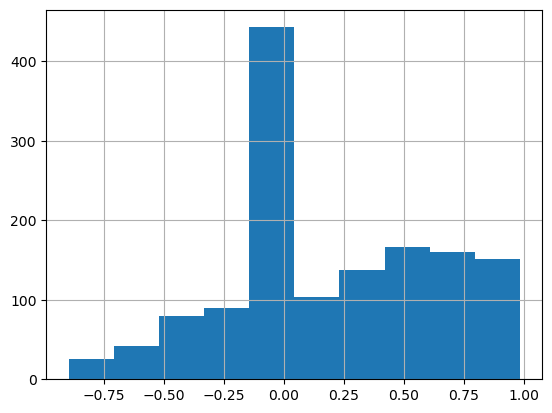

In [165]:
# Representation of the values generated by vaderSentiment
cleaned_train_df['vader_compound'].hist(); 
cleaned_train_df['vader_compound'].describe().round(3)

In [143]:
# Performance evaluation with metrics in contrast to real labels
#❓ Should we create a class to do the comparisons ?
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if 'sentiment' in cleaned_train_df.columns:
    
    accuracy = accuracy_score(cleaned_train_df['sentiment'], cleaned_train_df['vader_label'])
    precision = precision_score(cleaned_train_df['sentiment'], cleaned_train_df['vader_label'], average='weighted')
    recall = recall_score(cleaned_train_df['sentiment'], cleaned_train_df['vader_label'], average='weighted')
    f1 = f1_score(cleaned_train_df['sentiment'], cleaned_train_df['vader_label'], average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

Accuracy: 0.5854181558255898
Precision: 0.7558645762003526
Recall: 0.5854181558255898
F1-score: 0.628099210007195


In [175]:
# Assess sentiment classification models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, cut_off=0.5, plot_roc=True):
    """
        Helper function to assess a classification model in terms of the AUC
        and classification accuracy. We calculate the latter by comapring
        continuous (e.g., probabilistic) classifier predictions to a cut_off.
        Cases where the prediction exceeds the cut-off are classified as 
        positive.
    """
    # Calculate discrete class predictions
    yhat_c = np.where(yhat>cut_off, 1, 0)
    
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_c)
    auc = roc_auc_score(ytest, yhat)
    
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_c)
    
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    return(auc, acc, cmat)

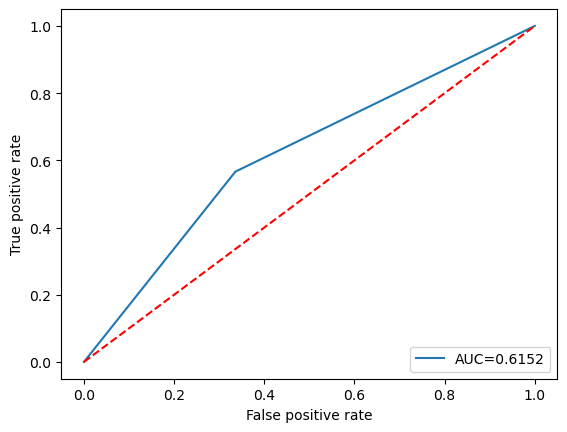

Lexicon-based sentiment classifier:	AUC=0.6152	Accuracy=0.5854


In [184]:
# Assess lexicon-based sentiment classifier
auc, acc, cmat = assess_sentiment_classifier(ytest=cleaned_train_df['sentiment'], yhat=cleaned_train_df['vader_label'], cut_off=0)
print("Lexicon-based sentiment classifier:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))

In [187]:
cmat

array([[182,  92],
       [488, 637]], dtype=int64)

🔷 Argumentation of: <br>
Why we used these metrics <br>
Why weighted average is important to use <br>
🔷 Explanation of the results, what do them imply? <br>
check #https://github.com/Humboldt-WI/delta/blob/master/demos/nlp/sentiment_analysis.ipynb <br>
Some ideas: <br>
- It can be not the most suitable thing to emply as the it assigns polarity scores including 0 which is neutral, whereas or real labels don't have a neutral value
- It's a simple/ straightforward method to apply sentiment analysis.

## Text data representation / Embedding: FastText

In [ ]:
from gensim.models import FastText

# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets_FT = [tweet.split() for tweet in cleaned_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets_FT, vector_size=100, window=3, min_count=5, sg=1, epochs=10)

# Save the model
fasttext_model.save("fasttext.model")

# Load the model (for future use)
fasttext_model = FastText.load("fasttext.model")

🔷 Argumentation of why we set the parameters like that. Explanation in notion

In [252]:
#Getting to know the vocabulary

# Number of words in the vocabulary
vocab_size = len(fasttext_model.wv)
print(f"Number of words in the vocabulary: {vocab_size}")

# Words and their counts
word_counts = {word: fasttext_model.wv.get_vecattr(word, "count") for word in fasttext_model.wv.index_to_key}

# Top 5 most frequent words
top_5_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:5]
print("Top 5 words and their occurrences:")
for word, count in top_5_words:
    print(f"{word}: {count}")

Number of words in the vocabulary: 1008
Top 5 words and their occurrences:
bitcoin: 1092
btc: 772
crypto: 341
eth: 230
amp: 161


In [238]:
# See the vector for a specific word 
word_info = 'bitcoin' 
print(f"Vector for '{word_info}':\n: {fasttext_model.wv[word_info]}")

# Get most similar words
print(f"Words similar to '{word_info}':\n: {fasttext_model.wv.most_similar(word_info)}")

Vector for 'bitcoin':
: [ 0.1321453   0.12010717  0.04648108  0.16354541  0.07435092  0.17683123
  0.0461157   0.27213517  0.09930971 -0.2037804  -0.13120864 -0.03159364
  0.01838671  0.386711    0.21967079 -0.2846033   0.00816252 -0.00310216
 -0.21321578 -0.43916965 -0.20946917  0.0541461   0.27496937 -0.08217407
 -0.12067789 -0.11522529 -0.07398232  0.18454635  0.03429808 -0.16177458
  0.11932881  0.27889326  0.16988038  0.17900886 -0.3388475   0.34745264
 -0.0322962   0.09571039 -0.36981082  0.18969087 -0.25206098 -0.13307747
  0.1449645  -0.2836776  -0.25226203 -0.2699835  -0.17970455 -0.15076378
 -0.07728162  0.08858436  0.21311939  0.02643363  0.266006   -0.06956034
 -0.15955694 -0.07029492 -0.00086952 -0.19871049 -0.00430273 -0.08045126
 -0.11204569 -0.09096897 -0.29110548  0.06616174  0.1393991   0.16509531
 -0.02623042 -0.16407897 -0.10242737  0.03392855  0.00156191 -0.04851926
  0.05187404 -0.25078565  0.10735223 -0.11914465  0.10927148 -0.16387798
  0.04575658  0.04917726 -0

## 2. RNN-based Language Classifier

In [270]:
# ⚠️ Check if we used all imported libraries 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Data partitioning for validation set
X_train, X_val, y_train, y_val = train_test_split(cleaned_train_df['cleaned_content'],cleaned_train_df['sentiment'], test_size = 0.2, random_state = 5)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1119,), (280,), (1119,), (280,))

### Vocabulary building

In [326]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=2000, oov_token=1)
# The oov_token is a placeholder token that replaces any OOV words during the text_to_sequence calls.
#This ensures that the model can handle new, unseen words gracefully.
tokenizer.fit_on_texts(X_train)

In [349]:
# Getting to know the vocabulary

#Check the vector dimensions using it with Keras
vector_dim = fasttext_model.wv.vector_size
print(f"Dimension of word vectors: {vector_dim}")

# Number of words in the vocabulary
print("Number of unique words:", len(tokenizer.word_counts))

# Top 5 most frequent words
top_n_words = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 most frequent words:")
for word, count in top_n_words:
    print(f"{word}: {count}")

Dimension of word vectors: 100
Number of unique words: 5459
Top 5 most frequent words:
bitcoin: 879
btc: 612
crypto: 270
eth: 172
amp: 122


In [320]:
# See the vector for a specific word
word_info = 'bitcoin'
n = tokenizer.word_docs[word_info]
print('The word <{}> appeared in {} tweets.'.format(word_info, n))

The word <bitcoin> appeared in 774 tweets.


In [331]:
# Convert each text into a sequence of integers,
# where each integer represents a specific word in the tokenizer's vocabulary.
# Based on the X_train's 'fit_on_texts'
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

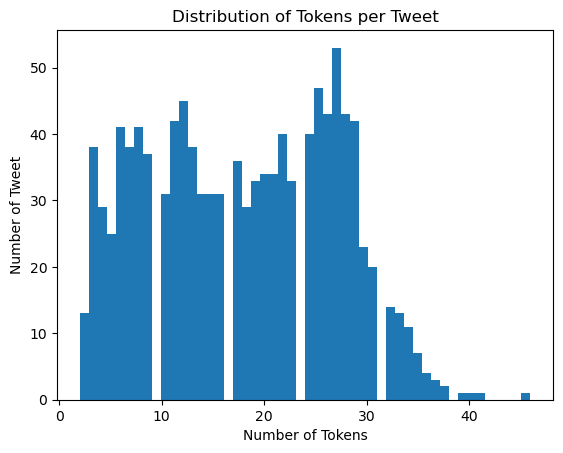

In [335]:
# Calculate the number of tokens per tweet
tokens_per_tweet = [len(seq) for seq in X_train_seq]

# Plot the distribution
plt.hist(tokens_per_tweet, bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweet')
plt.title('Distribution of Tokens per Tweet')
plt.show()

In [338]:
# Calculate the 95th percentile of the number of tokens per tweet
max_length = int(np.percentile(tokens_per_tweet, 95))
print(f"Recommended max length for padding: {max_length}")

Recommended max length for padding: 32


In [341]:
# Pad the sequences
max_length = 32  # Set max length for padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

#### Using Pre-trained Embeddings from FastText
In order to leverage the FastText embeddings we previously generated, we create an Embedding layer in Keras that uses the FastText embeddings:

In [353]:
# Create an embedding matrix
embedding_dim = 100  # Must match the dimension of FastText vectors
vocab_size = len(tokenizer.word_index) + 1   #it's the total number of unique words in your tokenizer’s vocabulary plus one. The +1 accounts for the padding token (index 0).
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #embedding_matrix is initialized as a matrix of zeros with shape (vocab_size, embedding_dim). 
                                                        #This matrix will eventually hold the FastText vectors for each word in your vocabulary.

for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (5461, 100)


In [366]:
X_val_pad

array([[  1, 468,   1, ...,   0,   0,   0],
       [130,  49,   4, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [  3, 444,   1, ...,   0,   0,   0],
       [  1,   1,  33, ...,   0,   0,   0],
       [301, 342, 435, ...,   0,   0,   0]])

### Logistic benchmark model

In [368]:
# ⚠️❓❌ Maybe we don't need this

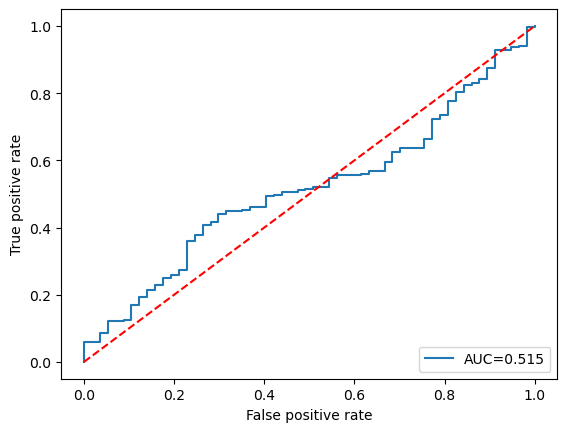

LASSO sentiment classifier:	AUC=0.5150	Accuracy=0.7964


In [363]:
# Estimate LASSO model
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="liblinear", penalty='l1')
classifier.fit(X_train_pad, y_train)
yhat_lr = classifier.predict_proba(X_val_pad)[:,1]  # output is probability of both classes

# Compute performance
auc, acc, cmat = assess_sentiment_classifier(y_val, yhat_lr)
print("LASSO sentiment classifier:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))

## Models comparison

See https://github.com/Humboldt-WI/delta/blob/master/demos/nlp/sentiment_analysis.ipynb <br>
Create a container in which we store the results of different models. Good options are either a dictionary or a data set. In this notebook, we use the latter approach. To ensure comparability across different approaches, we will re-calculate the performance of the lexicon-based model for the observations of the test set.